<h1>5 EigenFaces</h1>

In [291]:
import sklearn
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import os
import cv2

def get_faces(img):
    faceCascadeFront = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faceCascadeProfile = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_profileface.xml")
    faces_profile = np.array(faceCascadeProfile.detectMultiScale(
        img,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    ))
    faces_front = np.array(faceCascadeFront.detectMultiScale(
        img,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    ))
    faces = np.concatenate((faces_front.flatten(),faces_profile.flatten())).reshape(-1,4)
    output = []
    for (x,y,w,h) in faces:
        output.append(img[int(y):int(y+h),int(x):int(x+w)])
    return output

In [292]:
#Load Faces & Tags
datapath = "data/"
people = ["SWAROOP","AWAIS","MAI","JACOB","LILY"]
train_faces = []
train_labels = []
for person in people:
    path = datapath + person + "_TRAIN"
    pics = os.listdir(path)
    for file in pics:
        if not (file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg')): 
            continue
        img = cv2.imread(f'{path}/{file}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,(256,256),interpolation=cv2.INTER_AREA)
        train_faces.append(img)
        train_labels.append(person)

In [293]:
def compute_eigen_faces(face_list, num_components=50):
    #Flatten each face into a vector (each face must be the same size)
    face_list = face_list.flatten().reshape(len(face_list),-1)
    pca = PCA(n_components=num_components)
    pca.fit(face_list)
    return pca

In [294]:
pca = compute_eigen_faces(np.array(train_faces))

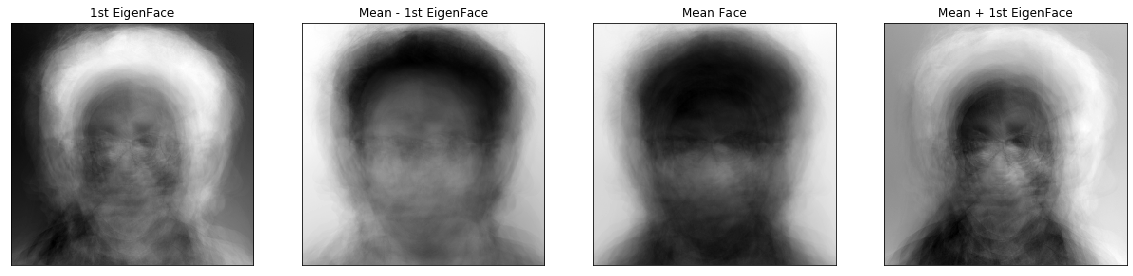

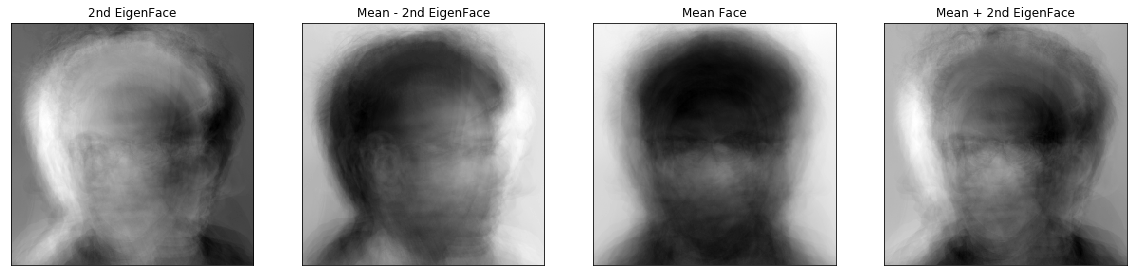

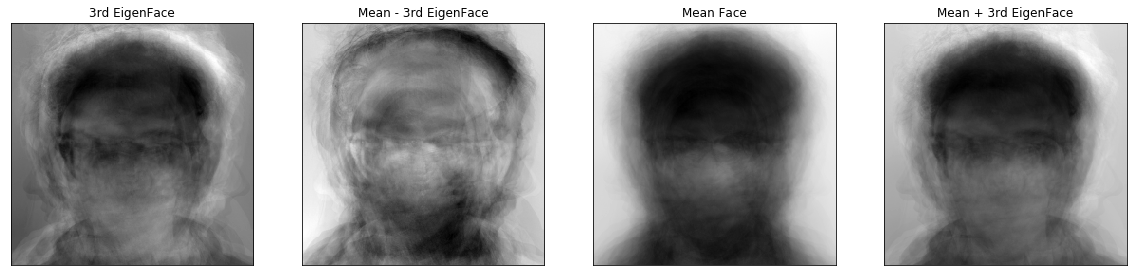

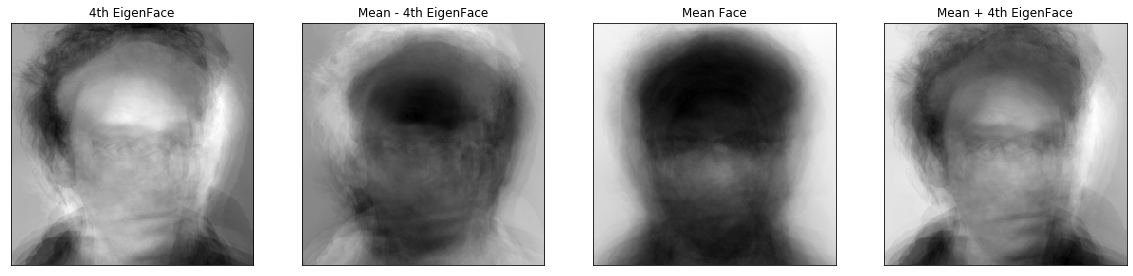

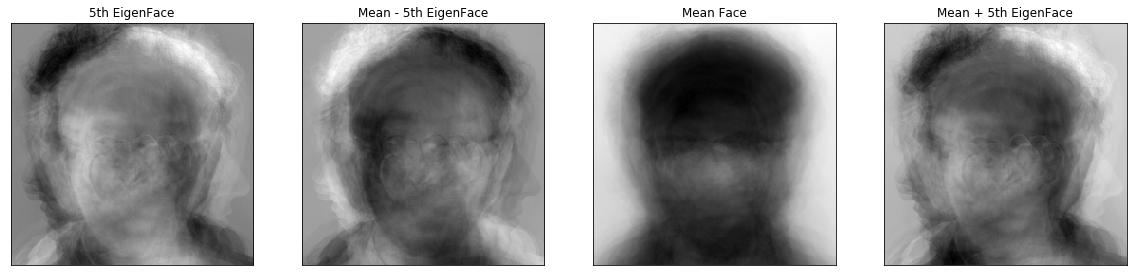

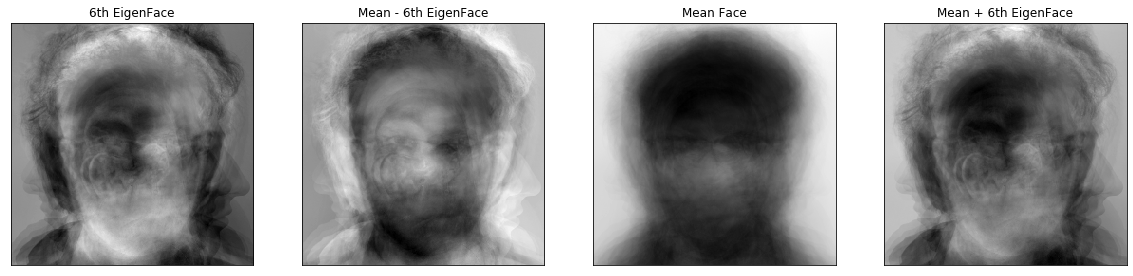

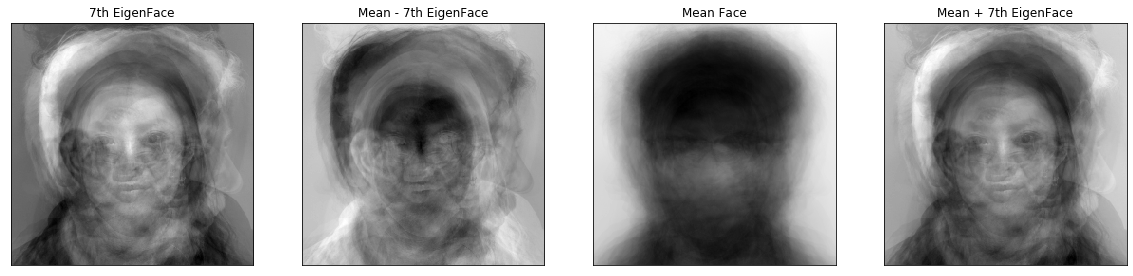

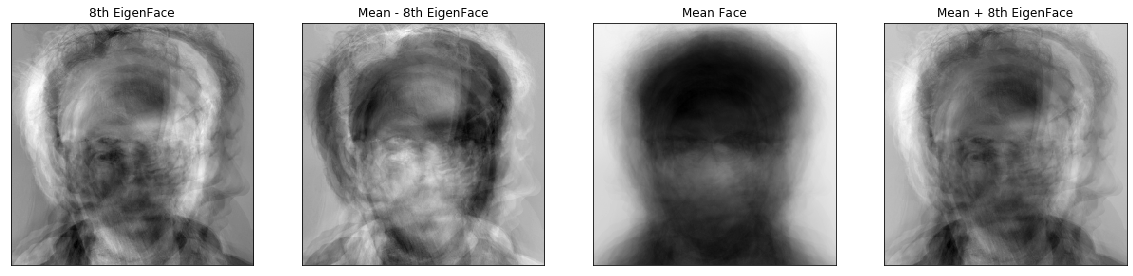

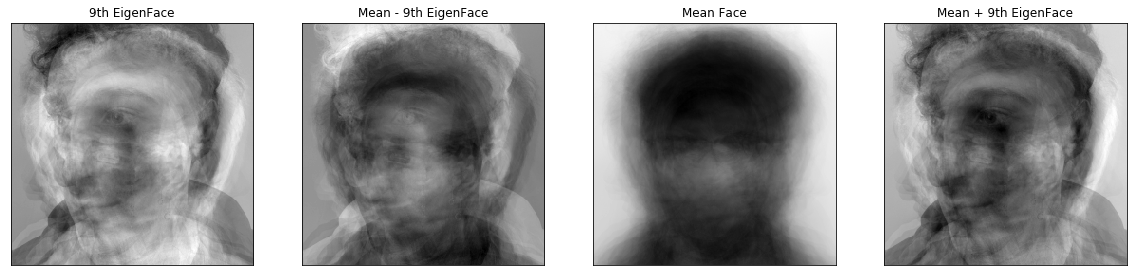

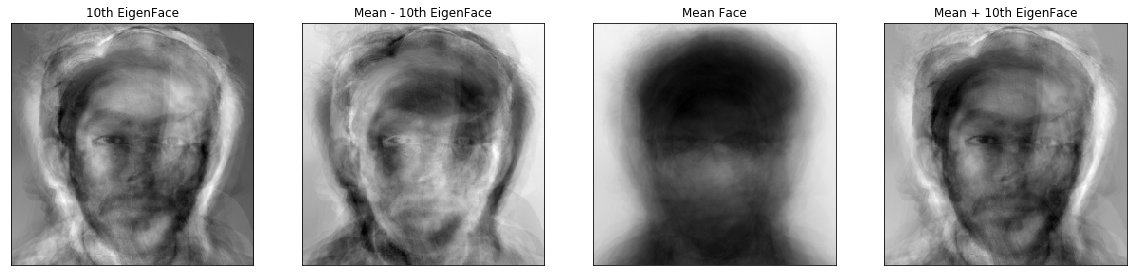

In [295]:
# Display the first 10 eigen faces
#start with the first eigen face to verify accuracy
#first_eig = pca.components_[0]
#first_face = (first_eig).reshape(256,256)
#plt.imshow(first_face,cmap='gray')
#plt.show()
#This line was taken from stack overflow to do ordinal endings
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])
for i in range(10):
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.title(f"{ordinal(i+1)} EigenFace")
    plt.imshow(pca.components_[i].reshape(256,256), cmap='gray')
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,4,2)
    plt.title(f"Mean - {ordinal(i+1)} EigenFace")
    plt.imshow((pca.mean_ - 10000*pca.components_[i]).reshape(256,256), cmap='gray')
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,4,3)
    plt.title(f"Mean Face")
    plt.imshow(pca.mean_.reshape(256,256), cmap='gray')
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,4,4)
    plt.title(f"Mean + {ordinal(i+1)} EigenFace")
    plt.imshow((pca.mean_ + 10000*pca.components_[i]).reshape(256,256), cmap='gray')
    plt.xticks([]), plt.yticks([])
    #Display mean +/- the eigenface to try to ascertain significance
    plt.show()

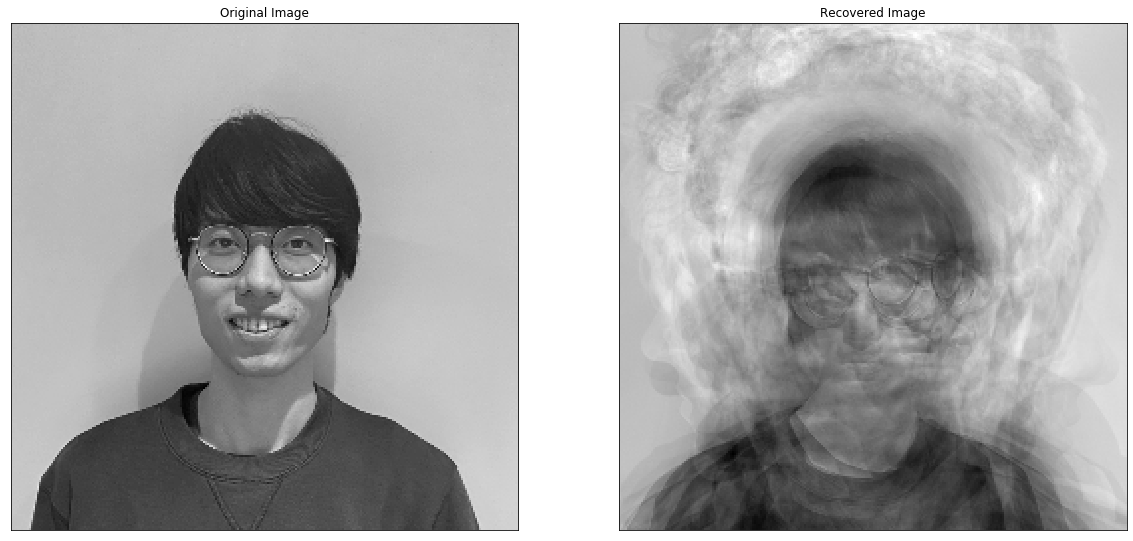

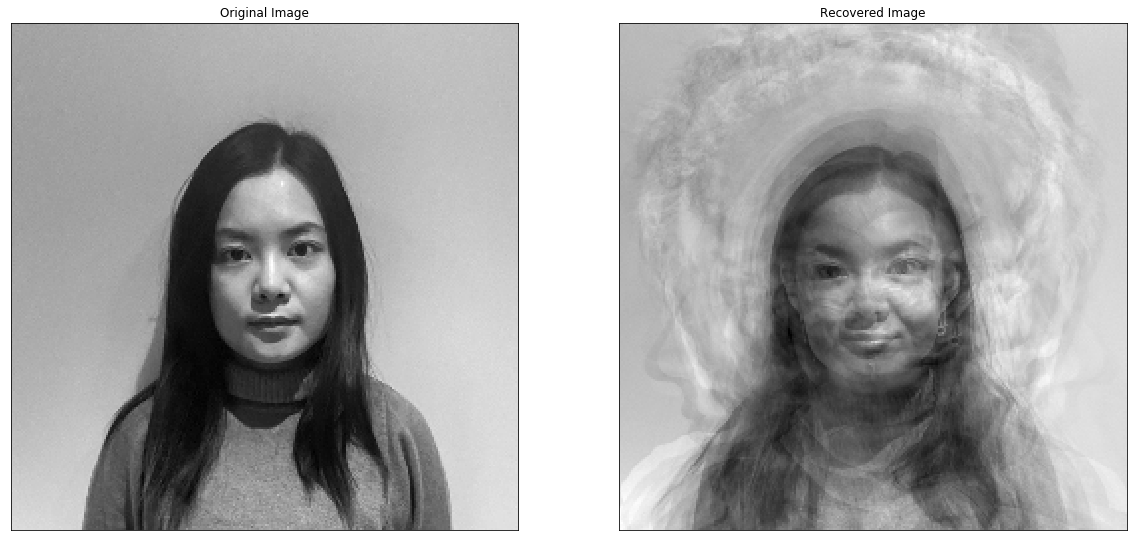

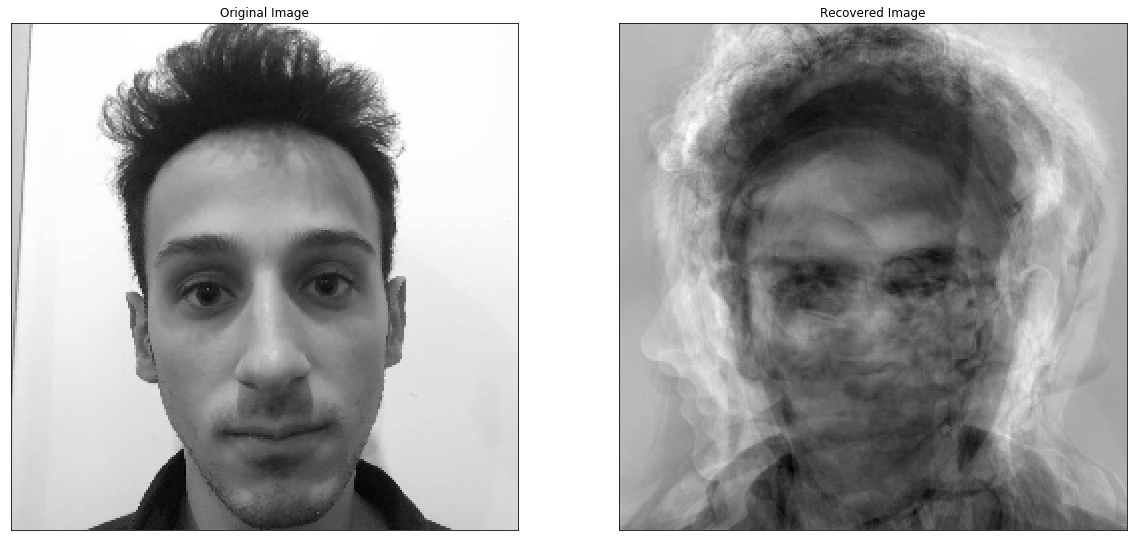

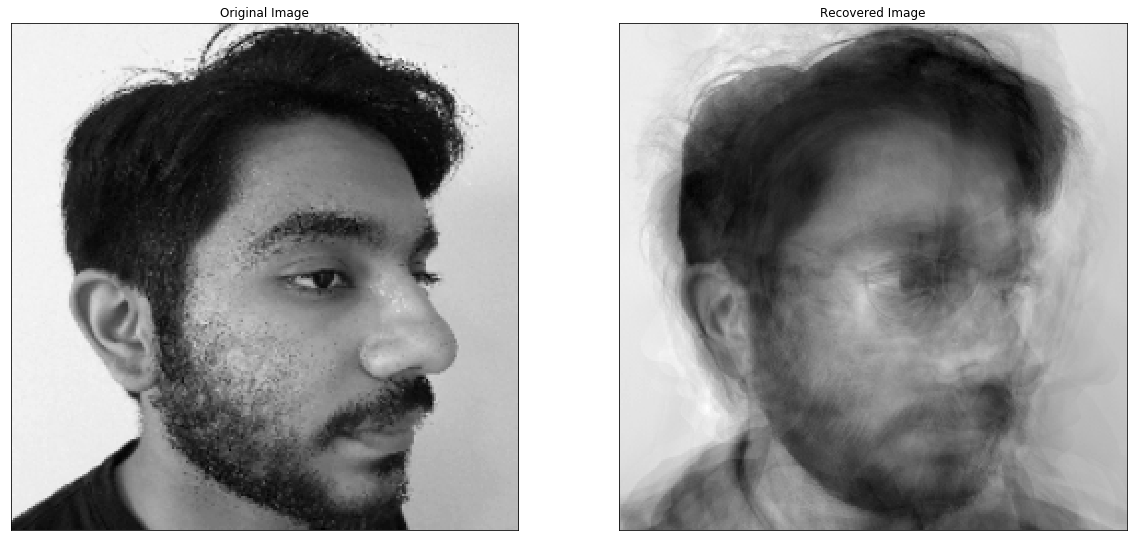

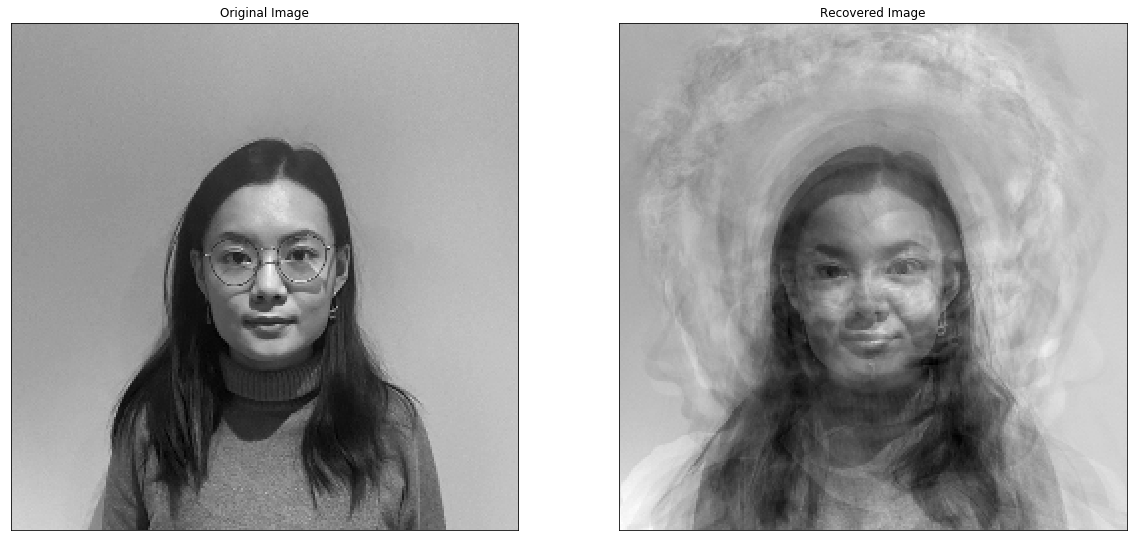

In [296]:
#Check loss
test_paths = ["data/MAI_TEST/MAI_8.png","data/LILY_TEST/LILY_3.png","data/JACOB_TEST/Test5.jpg",
             "data/AWAIS_TEST/AWAIS_7.png","data/LILY_TEST/LILY_10.png"]
for path in test_paths:
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.xticks([]), plt.yticks([])
    test_img = cv2.imread(path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    test_img = cv2.resize(test_img,(256,256))
    plt.imshow(test_img,cmap='gray')
    plt.subplot(1,2,2)
    plt.title("Recovered Image")
    plt.xticks([]), plt.yticks([])
    vector_img = test_img.flatten()
    eigen_version = pca.transform([vector_img])
    lossy = pca.inverse_transform(eigen_version).reshape((256,256))
    plt.imshow(lossy, cmap='gray')
    plt.show()

In [297]:
#Convert known faces to PCA repn's
train_eigen_faces = []
for face in train_faces:
    flat = face.flatten()
    train_eigen_faces.append(flat)
train_eigen_faces = pca.transform(train_eigen_faces)

In [298]:
def identify_face(face):
    face = cv2.resize(face,(256,256)).flatten()
    eig_face = pca.transform([face])[0]
    best_person = ''
    best_distance = float('inf')
    for i,known_face in enumerate(train_eigen_faces):
        d = np.linalg.norm(known_face - eig_face)
        if d < best_distance:
            best_person = train_labels[i]
            best_distance = d
    return best_person

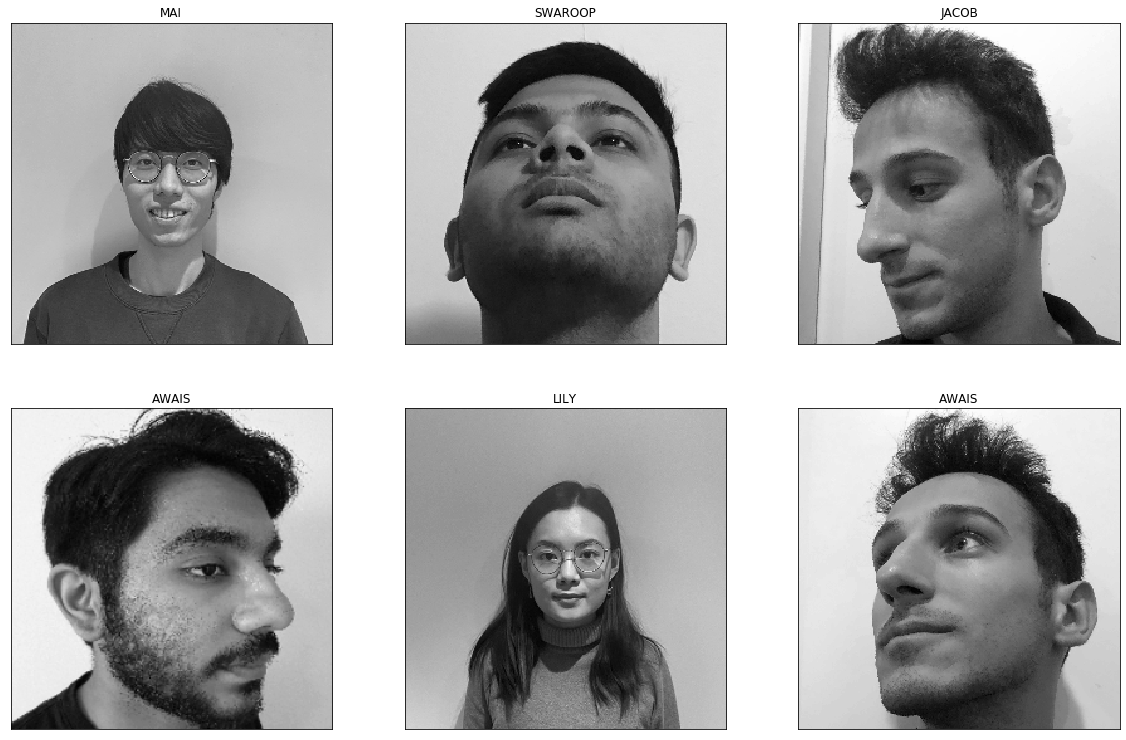

In [301]:
test_paths = ["data/MAI_TEST/MAI_8.png","data/SWAROOP_TEST/Test_2.jpeg","data/JACOB_TEST/Test1.jpg",
             "data/AWAIS_TEST/AWAIS_7.png","data/LILY_TEST/LILY_10.png","data/JACOB_TEST/Test6.jpg"]
plt.figure(figsize=(20,13))
for i,path in enumerate(test_paths):
    test_img = cv2.imread(path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    test_img = cv2.resize(test_img,(256,256))
    plt.subplot(2,3,i+1)
    plt.xticks([]),plt.yticks([])
    plt.title(identify_face(test_img))
    plt.imshow(test_img,cmap='gray')
plt.show()